### Load the saved dataset

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

df = pd.read_csv(PROJECT_ROOT / "data" / "imdb_raw.csv")
df.head()

,review,label,length,split
0,Bromwell High is a cartoon comedy. It ran at t...,1,806.0,train
1,Homelessness (or Houselessness as George Carli...,1,2366.0,train
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,841.0,train
3,This is easily the most underrated film inn th...,1,663.0,train
4,This is not the typical Mel Brooks film. It wa...,1,647.0,train


In [2]:
# checking
df['label'].value_counts()

label
1    25000
0    25000
Name: count, dtype: int64

#### Create train/val split

In [4]:
from sklearn.model_selection import train_test_split

X = df['review'].values
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

(len(X_train), len(X_val))

(40000, 10000)

### Import our baseline pipeline

In [5]:
from models.baseline import build_baseline_pipeline, BaselineConfig

config = BaselineConfig(
    max_features=20000,   # TF-IDF vocabulary size
    ngram_range=(1, 2),
    C= 1.0,
    random_state=42
)

pipeline = build_baseline_pipeline(config)
pipeline

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Train the model

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [7]:
# make predictions:
preds = pipeline.predict(X_val)

#### Evaluation

#### Accuracy

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy:", acc)
print("F1:", f1)

Accuracy: 0.9046
F1: 0.9055071315372425


In [9]:
# Full classification report:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Confusion matrix

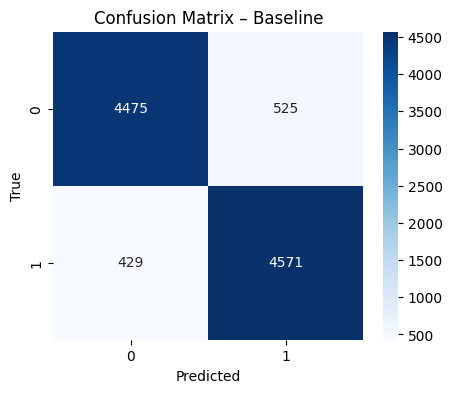

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Baseline")
plt.show()

### Inspect errors

In [11]:
df_val = pd.DataFrame({
    "review": X_val,
    "true": y_val,
    "pred": preds
})

mistakes = df_val[df_val["true"] != df_val["pred"]]
mistakes.head()

,review,true,pred
7,This movie was very disappointing in that seve...,0,1
8,Well...i was going to wait till this came out ...,0,1
10,How the Grinch Stole Christmas was a wonderful...,0,1
14,I saw this film when it came out. Let me see n...,0,1
21,when the gilmore girls started in Germany i di...,1,0


In [12]:
# sample
for i in range(5):
    row = mistakes.sample(1).iloc[0]
    print("TRUE:", row.true, "PRED:", row.pred)
    print(row.review[:600], "\n" + "-"*80)

TRUE: 1 PRED: 0
i was having a horrid day but this movie grabbed me, and i couldn't put it down until the end... and i had forgotten about my horrid day. and the ending... by the way... where is the sequel!!!<br /><br />the budget is obviously extremely low... but ... look what they did with it! it reminds me of a play... they are basically working with a tent, a 'escape pod', a few guns, uniforms, camping gear, and a 'scanner' thing. that is it for props. Maybe this is even a good thing, forcing the acting and writing to have to step up and take their rightful place in film, as the centers of the work, inste 
--------------------------------------------------------------------------------
TRUE: 1 PRED: 0
Big fat liar is a pretty funny movie. But as I was watching it, I thought about something. Some of the events that occur in this film are unbelievable. So really, the film is kind of a big fat lie. There is no way that he could've gotten away with all of this. Here are all of the unbe

### Preprocessing improvements

In [13]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)  # remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # remove weird symbols
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return text.strip()

In [14]:
df['clean'] = df['review'].apply(clean_text)

In [15]:
X = df['clean'].values
y = df['label'].values

X_train_clean, X_val_clean, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

(len(X_train), len(X_val))

(40000, 10000)

In [16]:
config = BaselineConfig(
    max_features=20000,   # TF-IDF vocabulary size
    ngram_range=(1, 2),
    C= 1.0,
    random_state=42
)

pipeline = build_baseline_pipeline(config)
pipeline

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [17]:
pipeline.fit(X_train_clean, y_train)

,steps,"[('tfidf', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [18]:
preds_clean = pipeline.predict(X_val_clean)

In [19]:
acc = accuracy_score(y_val, preds_clean)
f1 = f1_score(y_val, preds_clean)

print("Accuracy:", acc)
print("F1:", f1)

Accuracy: 0.9052
F1: 0.9061571965947337


In [20]:
print(classification_report(y_val, preds_clean))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



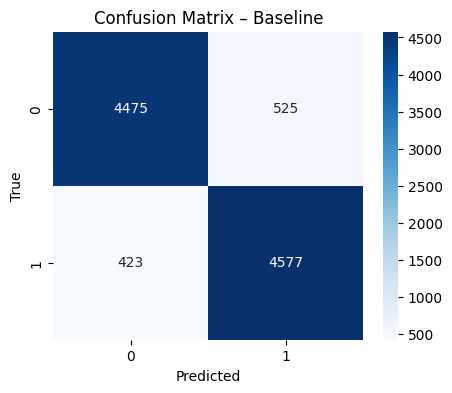

In [21]:
cm = confusion_matrix(y_val, preds_clean)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Baseline")
plt.show()

#### Build improved TF-IDF + LogReg pipeline

Let’s create 3 pipeline versions and compare them.

In [22]:
# VERSION A — unigrams only
config_A = BaselineConfig(max_features=15000, ngram_range=(1,1), C=1.0)
pipe_A = build_baseline_pipeline(config_A)
# VERSION B — unigrams + bigrams (your baseline improved)
config_B = BaselineConfig(max_features=30000, ngram_range=(1,2), C=1.0)
pipe_B = build_baseline_pipeline(config_B)
# VERSION C — stronger model (more features, tuned C)
config_C = BaselineConfig(max_features=50000, ngram_range=(1,2), C=2.0)
pipe_C = build_baseline_pipeline(config_C)

#### Training all 3 models

In [23]:
pipelines = {
    "A_unigrams": pipe_A,
    "B_uni+bi": pipe_B,
    "C_large+tuned": pipe_C
}

results = {}

for name, model in pipelines.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_clean, y_train)
    preds = model.predict(X_val_clean)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    results[name] = (acc, f1)
    print(f"{name} → acc={acc:.4f}, f1={f1:.4f}")



Training A_unigrams...
A_unigrams → acc=0.8951, f1=0.8961

Training B_uni+bi...
B_uni+bi → acc=0.9060, f1=0.9069

Training C_large+tuned...
C_large+tuned → acc=0.9112, f1=0.9119


#### Inspect most important positive/negative words

In [24]:
best = pipelines["C_large+tuned"]
tfidf = best.named_steps['tfidf']
logreg = best.named_steps['logreg']

feature_names = tfidf.get_feature_names_out()
coef = logreg.coef_[0]

##### Top 20 positive words:

In [25]:
top_pos = coef.argsort()[-20:][::-1]
[(feature_names[i], coef[i]) for i in top_pos]

[('great', np.float64(10.123813203944616)),
 ('excellent', np.float64(7.907650214634243)),
 ('perfect', np.float64(6.355413048886823)),
 ('amazing', np.float64(6.062254903051473)),
 ('wonderful', np.float64(5.992621785288855)),
 ('today', np.float64(5.363113955682427)),
 ('fun', np.float64(5.324808257333847)),
 ('best', np.float64(5.131724814099051)),
 ('brilliant', np.float64(5.131527207215943)),
 ('loved', np.float64(4.996599945402476)),
 ('hilarious', np.float64(4.855075407559803)),
 ('the best', np.float64(4.722348280433572)),
 ('superb', np.float64(4.63197307081007)),
 ('highly', np.float64(4.37804592719698)),
 ('enjoyed', np.float64(4.359030394731784)),
 ('favorite', np.float64(4.164085323167945)),
 ('fantastic', np.float64(4.110934280590847)),
 ('enjoyable', np.float64(4.093994453483111)),
 ('still', np.float64(3.944042401814479)),
 ('gem', np.float64(3.925195241129842))]

##### Top 20 negative words:

In [26]:
top_neg = coef.argsort()[:20]
[(feature_names[i], coef[i]) for i in top_neg]

[('worst', np.float64(-10.59861991577904)),
 ('bad', np.float64(-10.55140925167891)),
 ('awful', np.float64(-9.332956813947392)),
 ('boring', np.float64(-8.343376157579964)),
 ('the worst', np.float64(-8.126293497200049)),
 ('terrible', np.float64(-7.175252771797089)),
 ('waste', np.float64(-7.1435839348384125)),
 ('poor', np.float64(-7.0208395744548495)),
 ('nothing', np.float64(-6.2839299724183615)),
 ('horrible', np.float64(-6.032213091092017)),
 ('worse', np.float64(-5.944328517660083)),
 ('dull', np.float64(-5.865374505566447)),
 ('poorly', np.float64(-5.6655051249245085)),
 ('stupid', np.float64(-5.392856047700054)),
 ('lame', np.float64(-5.213505277954875)),
 ('disappointment', np.float64(-5.1661915258499205)),
 ('disappointing', np.float64(-5.049843936978602)),
 ('minutes', np.float64(-5.027546690926009)),
 ('ridiculous', np.float64(-4.945047106715784)),
 ('unfortunately', np.float64(-4.748736814073706))]

#### Prediction Function (Need to be corrected)

In [27]:
def predict_sentiment(text: str):
    model.eval()
    device = model.device
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits.softmax(dim=1)[0].cpu().numpy()

    pred_class = int(probs.argmax())
    confidence = float(probs.max())
    label = "positive" if pred_class == 1 else "negative"
    return label, confidence

#### Saving the final baseline model

In [28]:
import joblib

save_path = PROJECT_ROOT / "model_baseline.pkl"
joblib.dump(best, save_path)

print("Saved model to:", save_path)

Saved model to: C:\Users\Антон\OneDrive\Документы\Machine Learning\Projects\imdb-sentiment\model_baseline.pkl


In [29]:
import joblib

save_path = PROJECT_ROOT / "baseline_logreg_tfidf.joblib"
# e.g. baseline_pipeline, best_model, etc.
joblib.dump(best, save_path)


['C:\\Users\\Антон\\OneDrive\\Документы\\Machine Learning\\Projects\\imdb-sentiment\\baseline_logreg_tfidf.joblib']